In [1]:
import warnings

warnings.filterwarnings("ignore")

import os.path
import ssm
import pickle
import numpy as np
import pandas as pd
import scipy
import copy
from tqdm import tqdm

from runwise_ts_log_data import get_ts_log_data_blocked

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import to_rgba
import seaborn as sns

from sympy.utilities.iterables import multiset_permutations
from ssm.util import *
from scipy.stats import ttest_ind, wilcoxon, ranksums

In [2]:
with open('pkl/emoprox2_dataset_timeseries+inputs_MAX85.pkl','rb') as f:
    orig_df = pickle.load(f)
subj_list = sorted(orig_df['pid'].unique())
# subj_list = subj_list[:] # remove first 30 subjects
orig_df = orig_df[orig_df['pid'].isin(subj_list)]

In [3]:
K = 6
D = 10
N = 85
num_subjs = 92
M=20
num_resamples = 500

In [4]:
with open(f'pkl/all_dfs_models_K{K}_D{D}_N{N}_{num_subjs}subjs_{num_resamples}resamples.pkl','rb') as f:
    all_dfs,all_models = pickle.load(f)

In [5]:
with open(f'pkl/state_masks_K{K}_D{D}_N{N}_{num_subjs}subjs_{num_resamples}resamples.pkl','rb') as f:
    state_masks = pickle.load(f)

In [6]:
for idx_resample in range(1,1+num_resamples):
    state_mask = state_masks[idx_resample][:K-1]
    if state_mask.sum()==0: 
        print(idx_resample)

133
223
404
473


In [7]:
winlen = 10

def get_begin_responses(y,z,v,st_i,win=winlen):
    ret = []
    ret_v = []
    ret_z = []
    for t in range(len(z)-win):
        if z[t]==st_i: 
            if t==0:
                # if np.all(z[t:t+6]==st_i):
                    ret.append(y[t:t+win])
                    ret_z.append(z[t:t+win])
                    ret_v.append(v[t:t+win])
            elif z[t-1]!=st_i:
                # if np.all(z[t:t+6]==st_i):
                    ret.append(y[t:t+win])
                    ret_z.append(z[t:t+win])
                    ret_v.append(v[t:t+win])
    # if len(ret)>0: return np.mean(np.stack(ret,axis=0),axis=0)
    # else: return None
    return ret,ret_z,ret_v



def bootstrap_err(sample):
    means = np.zeros(100)
    for i in range(100):
        means[i] = np.random.choice(sample,len(sample),replace=True).mean()
    return means.std()*1.96

def bootstrap_err_matrix(X):
    ret = np.zeros_like(X[0])
    for i in range(X[0].shape[0]):
        for j in range(X[0].shape[1]):
            ret[i,j] = bootstrap_err(X[:,i,j])
    return ret

from scipy.stats import mode

def get_mean_state_response(df,state_from):
    subj_list = df.pid.unique()
    begin_responses = []
    begin_states = []
    begin_vectors = []
    for pid in subj_list:
        df_subj = df[df.pid==pid]
        z_subj = np.hstack(list(df_subj.discrete_states.values))
        y_subj = np.vstack(list(df_subj['continuous_states'].values))
        v_subj = np.vstack(list(df_subj['inputvecs'].values))
        y_begin,z_begin,v_begin = get_begin_responses(y_subj,z_subj,v_subj,state_from)
        begin_responses += y_begin
        begin_states += z_begin
        begin_vectors += v_begin
    begin_responses = np.stack(begin_responses,axis=0)
    begin_states = np.stack(begin_states,axis=0)
    begin_vectors = np.stack(begin_vectors,axis=0)
    mean_begin_response = begin_responses.mean(axis=0)
    mean_begin_vector = begin_vectors.mean(axis=0)
    mode_begin_state = mode(begin_states)
    
    return mean_begin_response, mode_begin_state, mean_begin_vector

def get_inputvecs(df,model):
    df['inputvecs'] = [None]*df.shape[0]
    for idx_row in range(df.shape[0]):
        zs = df.loc[idx_row]['discrete_states'].copy()
        xs = df.loc[idx_row]['continuous_states'].copy()
        inputs = df.loc[idx_row]['input'].copy()
        inputvecs = np.zeros_like(xs)
        for t,[z,input] in enumerate(zip(zs[1:],inputs[1:])):
            inputvecs[t+1] = model.dynamics.Vs[z]@input
        df.at[idx_row,'inputvecs'] = inputvecs
        # print(inputvecs)
    return df

217
217
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)


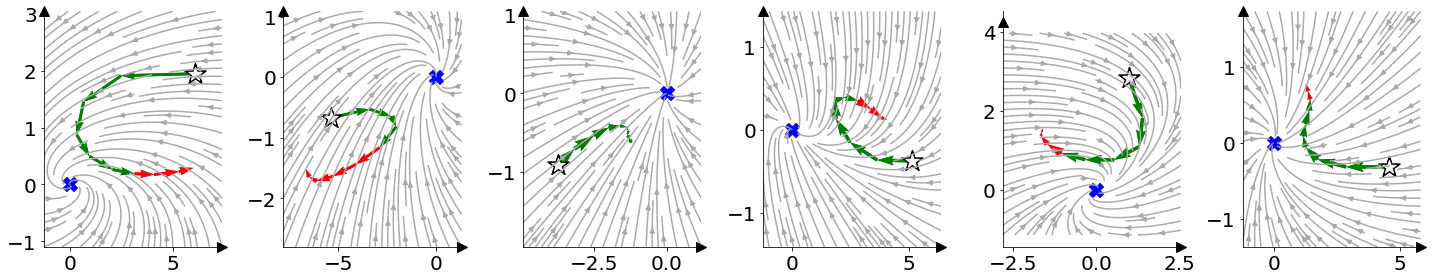

In [8]:

def get_flow1(normals,A,b,ax):
    xmin,xmax = ax.get_xlim()
    ymin,ymax = ax.get_ylim()
    num_points = 10
    xtup = (xmin-1,xmax+1, num_points)
    ytup = (ymin-1,ymax+1, num_points)

    apply_dynamics = lambda x: A @ x + b

    x_bar = (np.linalg.inv(np.eye(D)-A) @ b) 
    x_bar2d = (np.linalg.inv(np.eye(D)-A) @ b) @ normals

    two_to_lat = lambda x: (x) @ normals.T + x_bar
    lat_to_two = lambda x: x @ normals - x_bar2d
       
    x_range = np.linspace(*xtup)
    y_range = np.linspace(*ytup)
    x_coords, y_coords = np.meshgrid(x_range,y_range)

    us,vs = np.zeros_like(x_coords),np.zeros_like(y_coords)
    for idx_point,point in enumerate(zip(x_coords.flatten(), y_coords.flatten())):
        v = np.array(point) # 2D
        v_latent = two_to_lat(v) # latent space 
        
        v_next = lat_to_two(apply_dynamics(v_latent)) # 2D
        dv = v_next - v

        us[idx_point//num_points,idx_point%num_points] = dv[0]
        vs[idx_point//num_points,idx_point%num_points] = dv[1]
        # ax.quiver(v[0],v[1],dv[0],dv[1],units='xy',angles='xy',scale_units='xy',scale=1,width=0.05,color='k',alpha=0.3)

        # dv1 = lat_to_two(apply_dynamics(v_latent)-v_latent) # 2D
        # ax.quiver(v[0],v[1],dv1[0],dv1[1],units='xy',scale=1,width=0.05,color='r')
    ax.streamplot(x_coords,y_coords,us,vs,color='darkgrey')

def get_traj1(normals,x,A,b,ax,state,states):

    x_bar2d = (np.linalg.inv(np.eye(D)-A) @ b) @ normals
    lat_to_two = lambda x: x @ normals - x_bar2d

    x2d = np.zeros((x.shape[0],2))
    for t in range(x.shape[0]):
        x2d[t,:] = lat_to_two(x[t,:])

    for t in range(x.shape[0]-1):
        v = x2d[t,:]
        dv = x2d[t+1,:] - v
        if states[t]==state:
            ax.quiver(v[0],v[1],dv[0],dv[1],units='xy',angles='xy',scale_units='xy',scale=1,width=0.09,color='green')
        else:
            ax.quiver(v[0],v[1],dv[0],dv[1],units='xy',angles='xy',scale_units='xy',scale=1,width=0.09,color='red')
    ax.scatter(x2d[0,0],x2d[0,1],color='black',marker='*',s=500)
    ax.scatter(x2d[0,0],x2d[0,1],color='white',marker='*',s=200)

def get_v(normals,x,v,A,b,ax,state):
    x_bar2d = (np.linalg.inv(np.eye(D)-A) @ b) @ normals
    lat_to_two = lambda x: x @ normals - x_bar2d

    v12d = np.zeros((x.shape[0],2))
    v22d = np.zeros((x.shape[0],2))
    for t in range(x.shape[0]):
        v12d[t,:] = lat_to_two(x[t,:])
        v22d[t,:] = lat_to_two(x[t,:]+v[t,:])

    for t in range(x.shape[0]-1):
        v = v12d[t,:]
        dv = v22d[t,:] - v
        ax.quiver(v[0],v[1],dv[0],dv[1],units='xy',angles='xy',scale_units='xy',scale=0.3,width=0.09,color='m')


def get_fixed_point1(ax):
    ax.scatter(0,0,color='b',marker='X',s=200)

# 310,217,30
# 217 main paper
# 310 supp 1
# 30 supp 2
# 445 supp3    
# 26 supp 4
# 461 supp5
    
idx_resample = 217#np.random.randint(500)

df = all_dfs[idx_resample]
model = all_models[idx_resample]
df = get_inputvecs(df,model)
print(idx_resample)

As = model.dynamics.As
bs = model.dynamics.bs

xs = np.vstack(list(df['continuous_states'].values))

cov = np.corrcoef(xs.T)
U,Lam,V = np.linalg.svd(cov)
pcs = U[:,:2] # using top 2 principal components
print(idx_resample)
fig,axs = plt.subplots(nrows=1,ncols=K,figsize=(20,4),sharex=False,sharey=False)
for k in range(K):
    begin_resp, begin_state, begin_v = get_mean_state_response(df,k)
    print(begin_resp.shape)
    # all_resp = np.vstack([begin_resp,end_resp])
    sigma = begin_resp.T @ begin_resp
    U,Lam,V = np.linalg.svd(sigma)
    normals = U[:,:2]
    ax = axs[k]
    get_fixed_point1(ax)
    get_traj1(normals,begin_resp,As[k],bs[k],ax,k,begin_state.mode[0])
    get_flow1(normals,As[k],bs[k],ax)
    get_traj1(normals,begin_resp,As[k],bs[k],ax,k,begin_state.mode[0])
    # get_v(normals,begin_resp,begin_v,As[k],bs[k],ax,k)
    # get_traj1(normals,end_resp,As[k],bs[k],ax,'green')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # ax.set_title(f'State{k+1}',fontsize=20)
    ax.plot((0), (ax.get_ylim()[1]), ls="", marker="^", ms=10, color="k", transform=ax.get_yaxis_transform(), clip_on=False)
    ax.plot((ax.get_xlim()[1]), (0), ls="", marker=">", ms=10, color="k", transform=ax.get_xaxis_transform(), clip_on=False)
    # ax.set_xlabel('PC1',fontsize=20)
    # if k==0: ax.set_ylabel('PC2',fontsize=20)
    ax.tick_params(axis='both',labelsize=20)
fig.tight_layout()
fig.savefig(f'figures/fig_intrinsic_dynamics_trajectory_in_vector_field_K{K}_D{D}_{num_subjs}subjs_poster.jpg',dpi=600,bbox_inches='tight')

In [9]:


# def get_flow(xtup,ytup,A,b,ax):
#     xmin,xmax,xnum = xtup
#     ymin,ymax,ynum = ytup

#     apply_dynamics = lambda x: A @ x + b

#     x_bar = (np.linalg.inv(np.eye(D)-A) @ b) 
#     x_bar2d = (np.linalg.inv(np.eye(D)-A) @ b) @ pcs

#     two_to_lat = lambda x: x @ pcs.T + x_bar
#     lat_to_two = lambda x: x @ pcs - x_bar2d
       
#     x_range = np.linspace(*xtup)
#     y_range = np.linspace(*ytup)
#     x_coords, y_coords = np.meshgrid(x_range,y_range)
#     for point in zip(x_coords.flatten(), y_coords.flatten()):
#         v = np.array(point) # 2D
#         v_latent = two_to_lat(v) # latent space 
        
#         v_next = lat_to_two(apply_dynamics(v_latent)) # 2D
#         dv = v_next - v

#         dv1 = lat_to_two(apply_dynamics(v_latent)-v_latent) # 2D

#         ax.quiver(v[0],v[1],dv[0],dv[1],units='xy',scale=1,width=0.025,color='k')
#         # ax.quiver(v[0],v[1],dv1[0],dv1[1],units='xy',scale=1,width=0.05,color='r')

# def get_traj(x,A,b,ax):

#     x_bar2d = (np.linalg.inv(np.eye(D)-A) @ b) @ pcs
#     lat_to_two = lambda x: x @ pcs - x_bar2d

#     x2d = np.zeros((x.shape[0],2))
#     for t in range(x.shape[0]):
#         x2d[t,:] = lat_to_two(x[t,:])
    
#     for t in range(x.shape[0]-1):
#         v = x2d[t,:]
#         dv = x2d[t+1,:] - v
#         ax.quiver(v[0],v[1],dv[0],dv[1],units='xy',scale=1,width=0.05,color='r')

# def get_fixed_point(A,b,ax):
#     ax.scatter(0,0,color='b',marker='x',s=100)

# xlims = [(-1,3,15),(-6,1,15),(-3,1,15),(-2,8,15),(-3,1,15)]
# for k in range(K-1):
#     fig = plt.figure(figsize=(5,5))
#     ax = fig.add_subplot()
#     get_flow(xlims[k],(-2,2,15),As[k],bs[k],ax)
#     get_fixed_point(As[k],bs[k],ax)
#     mean_resp, _ = get_mean_transition_response(df,k)
#     get_traj(mean_resp,As[k],bs[k],ax)
#     ax.set_title(f'Flow diagram of State{k+1}',fontsize=15)